# First of all, import everything we need

In [1]:
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils.datasets import SupervisedDataset
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
import torch
import numpy as np
import matplotlib.pyplot as plt
from botorch.acquisition import ExpectedImprovement, PosteriorMean, ProbabilityOfImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.fit import fit_gpytorch_model


In [2]:
from ngboost import NGBRegressor
from ngboost.distns import MultivariateNormal

In [3]:
import scipy as sp

# Demo function that we plan to work with

In [4]:
def func(X):
    return -np.sin(3*X) - X**2 + 0.7*X 

# Generate samples

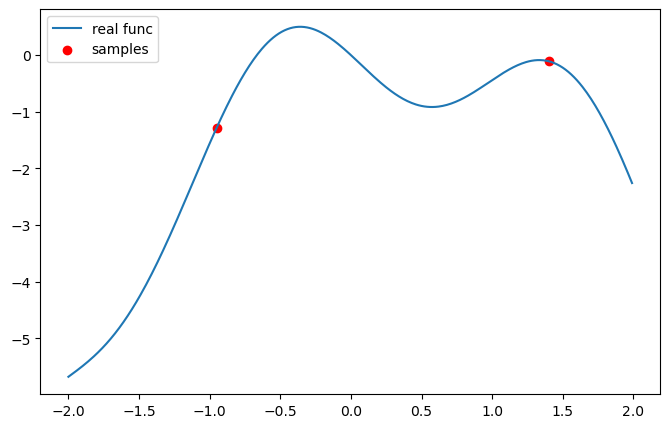

In [5]:
train_x = torch.Tensor([1.4, -0.95]).reshape(-1, 1)
train_y = func(train_x)

X = torch.arange(-2.0, 2.0, 0.01).reshape(-1, 1)
Y = func(X)

plt.figure(figsize=(8, 5))
plt.plot(X.squeeze(), Y.squeeze(), label='real func')
plt.scatter(train_x.squeeze(), train_y.squeeze(), c='r', label='samples')
plt.legend()
plt.show()

# Run this cell and get error with MultivariateNormal

In [6]:
ngboost = NGBRegressor(Dist=MultivariateNormal(2), n_estimators=100, verbose_eval=1).fit(train_x, train_y)

Y = ngboost.predict(train_x)
Y_dists = ngboost.pred_dist(train_x)

ValueError: operands could not be broadcast together with shapes (2,5) (2,) 

# These two cells were copied from ngboost repo https://github.com/stanfordmlgroup/ngboost/blob/master/ngboost/distns/multivariate_normal.py

In [7]:
N, p = train_y.shape
m = train_y.mean(axis=0)  # pylint: disable=unexpected-keyword-arg
diff = train_y - m
sigma = 1 / N * (diff[:, :, None] @ diff[:, None, :]).sum(0)
L = sp.linalg.cholesky(np.linalg.inv(sigma), lower=True)
diag_idx = np.diag_indices(p)
L[diag_idx] = np.log(L[diag_idx])

In [8]:
np.concatenate([m, L[np.tril_indices(p)]])

array([-0.69422305,  0.53477883], dtype=float32)

# Here is the problem. After concatenation we should get 5 parametrs (2 means, 2 sigmas and 1 corr). But we do not. 

# Let's see what sigma we have 

In [9]:
m, sigma

(tensor([-0.6942]), tensor([[0.3432]]))

# Seems like mean and sigma was calculated between all samples

# Let's resize the data

In [10]:
train_x = torch.Tensor([1.4, -0.95]).reshape(1, -1)
train_y = func(train_x).reshape(1, -1)

In [11]:
N, p = train_y.shape
m = train_y.mean(axis=0)  # pylint: disable=unexpected-keyword-arg
diff = train_y - m
sigma = 1 / N * (diff[:, :, None] @ diff[:, None, :]).sum(0)
L = sp.linalg.cholesky(np.linalg.inv(sigma), lower=True)
diag_idx = np.diag_indices(p)
L[diag_idx] = np.log(L[diag_idx])

LinAlgError: Singular matrix

In [12]:
m, sigma

(tensor([-0.1084, -1.2800]),
 tensor([[0., 0.],
         [0., 0.]]))

# These dimentions we need, but I am not sure that result was calculated properly...

# To be continued...